<a href="https://colab.research.google.com/github/PENNET-dev/hackathon-uW-2024/blob/main/2024_uW_Hackathon_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024 Hackathon - The Tone Rangers

Audio is a primary part of the human/computer interaction requried for Oral Bible Translation (OBT).  And some Bible translation efforts target "low resource languages".  As such, Bible translation software must understand spoken audio from low resource languages.

Here, we propose a model to recognize individual words in Dholuo.

Here, "low resource languages" is understood as any language that does not have open, available models for LLM, speech-to-text, and text-to-speech.

By requiring a "stable" model, we require the solution to be independent of tone, volume, speed, or the speaker's gender.

Thesis:
Find a stable method for recognizing individual words in low-resource languages.

# Literature Review:

## How Multilingual is Multilingual LLM?
https://openreview.net/pdf?id=VXNYBh_iGcfX

# PyTorch Speech Command Classification with torchaudio
https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

# wav2vec Speech Recognition with WAV2VEC2
https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html

## Audio Comparison Using MFCC and DTW
https://audiovideotestlab.com/blog/audio-comparison-using-mfcc-and-dtw/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
import os
from tqdm import tqdm

# List of libraries to install
libraries = ['SpeechRecognition', 'pyttsx3', 'audiosegment']

# Install libraries in silence
for lib in tqdm(libraries, desc="Installing libraries", unit="library"):
    os.system(f"pip install {lib} -q")


Installing libraries:   0%|          | 0/3 [00:00<?, ?library/s]

Installing libraries: 100%|██████████| 3/3 [00:26<00:00,  8.67s/library]


# Install the Libraries

In [3]:
# Import all required packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.fft
import scipy.fftpack as fft
from scipy.fftpack import dct
from scipy.signal import spectrogram
import librosa
import librosa.display
import IPython.display

import glob
import soundfile as sf
from scipy.spatial.distance import cosine

import speech_recognition as sr
import re
from pydub import AudioSegment
from pydub.silence import split_on_silence

# MFCC Walkthrough

Define the Plot functions

In [ ]:
def plot_time(audio, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(audio, alpha=0.5, label='audio')
    plt.grid(True)
    plt.title(title+' Sample - Time Domain')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.show();

In [ ]:
def fft(data, sample_rate, figsize=(15,4),title = ''):

    N = sample_rate
    # Compute FFT
    yf = scipy.fftpack.fft(data)
    print("yf", data.shape, yf.shape)

    # Generate frequency bins
    xf = np.linspace(0.0, sample_rate//2, N//2)
    print("xf", xf.shape)

    # Find the index of the maximum amplitude and its corresponding frequency
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    max_amplitude_idx = np.argmax(2.0/N * np.abs(yf[start_bin:N//2]))
    max_amplitude_frequency = xf[start_bin:][max_amplitude_idx]

    # Plot FFT (skipping the first 20 bins to start from 20 Hz)
    plt.figure(figsize=figsize)
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    print (xf[start_bin:].shape, yf[start_bin:N//2].shape)
    plt.semilogx(xf[start_bin:], 2.0/N * np.abs(yf[start_bin:N//2]))

    # Add a point and label for the frequency with the maximum amplitude
    plt.scatter(max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx]), color='red')
    plt.annotate(f'Max Amp. @ {max_amplitude_frequency:.2f} Hz',
                 (max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx])),
                 textcoords="offset points",
                 xytext=(10,-10),
                 ha='left')

   # plt.semilogx(2.0/N * np.abs(yf[20:N//2]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();
    return yf, max_amplitude_frequency


In [ ]:
def plot_spectogram(audio, sample_rate, figsize=(10,5), title=''):
    epsilon = 1e-10 # Small constant to avoid log10(0)
    frequencies, times, Sxx = spectrogram(audio, sample_rate)
    plt.figure(figsize=figsize)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + epsilon), shading='gouraud')
    plt.title(title+' Sample - Spectogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [4]:
def calc_plot_mfcc (audio, sample_rate, n_mfcc=13, figsize=(10,5), title=''):

    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # # Plotting the MFCCs
    plt.figure(figsize=figsize)
    librosa.display.specshow(mfccs,
                             x_axis='time',
                             sr=sample_rate,
                             cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('MFCC')
    plt.xlabel('time')
    plt.ylabel('MFCC Coefficients')
    plt.yticks(np.arange(0, 13, 1), [str(i+1) for i in range(13)])
    plt.title(title +' - Mel-frequency cepstral coefficients (MFCC)')
    plt.tight_layout()
    plt.show()

Analizyng Audio raw sample

In [ ]:
# Load audio file
def load_audio(audioSampleFilePath): #, sr=64000, duration=0.13):
    assert os.path.isfile(audioSampleFilePath), f"No file at {audioSampleFilePath}"
    print(os.path.getsize(audioSampleFilePath))
    data, sample_rate = librosa.load(audioSampleFilePath)
    print(data.shape, sample_rate)
    return data, sample_rate



In [ ]:
# # Audio sample
# audioFilePath_yes = "/content/InTheBeginning01.wav"
# yes, sample_rate = load_audio(audioFilePath_yes)

# print(yes.shape, sample_rate)

In [ ]:
# ZPP: Philip, is this correct?  I made some changes to fft()

def fft(data, sample_rate, figsize=(15,4), title=''):
    N = len(data)
    yf = scipy.fftpack.fft(data)
    xf = np.linspace(0.0, sample_rate//2, N//2)
    max_amplitude_idx = np.argmax(2.0/N * np.abs(yf[:N//2]))
    max_amplitude_frequency = xf[max_amplitude_idx]

    plt.figure(figsize=figsize)
    plt.semilogx(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.scatter(max_amplitude_frequency, 2.0/N * np.abs(yf[:N//2][max_amplitude_idx]), color='red')
    plt.annotate(f'Max Amp. @ {max_amplitude_frequency:.2f} Hz',
                 (max_amplitude_frequency, 2.0/N * np.abs(yf[:N//2][max_amplitude_idx])),
                 textcoords="offset points", xytext=(10,-10), ha='left')

    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show()

    return yf, max_amplitude_frequency

Plot the FFT

In [ ]:
#yf_yes, max_amp_freq_yes = fft(yes, sample_rate, figsize = (8,4), title = 'In The Beginning 01')

#print("fft", yf_yes, max_amp_freq_yes)

Plot Spectogram

In [ ]:
#plot_spectogram(yes, sample_rate, figsize = (8,4), title='In The Beginning 01')

MFCC Plot with Librosa

Librosa function is designed to handle the entire MFCC extraction process starting from the raw audio signal.

When you pass the raw audio signal to librosa.feature.mfcc, the function internally performs several steps including:

* Framing the signal into overlapping frames.
* Applying a window function to each frame.
* Calculating the FFT to convert each frame to the frequency domain.
* Applying Mel filter banks to the frequency spectra.
* Taking the logarithm of the Mel frequencies.
* Performing the Discrete Cosine Transform (DCT).

In [ ]:
#calc_plot_mfcc (yes, sample_rate, n_mfcc=13, figsize = (8,4), title='In The Beginning 01')

The above plot was generated with the default Librosa MFCC package parameters.

# Generating MFCC Features

## MFCC Calculation and plot using numpy and scipy libraries

In [ ]:
#audio = yes.copy()
#type(audio)

## Pre-emphasis: Apply a pre-emphasis filter to high-pass filter the audio signal:

In [ ]:
#alpha = 0.98 #Coefficient
#audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

## Framing: Split the signal using frame lenght of 25 milliseconds with a Frame stride of 20 milliseconds:

In [ ]:
# Parameters
#frame_size = 0.025  # frame size in seconds
#frame_stride = 0.020  # frame stride in seconds

# Calculate frame length and frame step (convert from seconds to samples)
#frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
#frame_length = int(round(frame_length))
#frame_step = int(round(frame_step))

# Calculate the total number of frames
#num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

#frame_length, frame_step, num_frames

In [ ]:
# Pad audio signal
#pad_audio_length = num_frames * frame_step + frame_length
#z = np.zeros((pad_audio_length - len(audio)))
#pad_audio = np.append(audio, z)

In [ ]:
#pad_audio.shape

In [ ]:
# Initialize the frames
#indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
#frames = pad_audio[indices.astype(np.int32, copy=False)]

In [ ]:
#frames.shape

## Windowing: Apply a Hamming window to each frame:

In [ ]:
# Apply window function (Hamming)
#frames *= np.hamming(frame_length)
#frames[0].shape

In [ ]:
#plot_time(frames[5], figsize = (5,3), title='frame[5]')
#plot_time(frames[25], figsize = (5,3), title='frame[25]')
#plot_time(frames[40], figsize = (5,3), title='frame[40]')

## Fast Fourier Transform (FFT): Perform FFT to convert the frames to frequency domain:

In [ ]:
# Perform FFT and calculate power spectrum
#NFFT = 512 # FFT lenght
#mag_frames = np.absolute(np.fft.fft(frames, NFFT))
#pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
#mag_frames = mag_frames[:, :NFFT//2 + 1]
#pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
#mag_frames.shape, pow_frames.shape

In [ ]:
def plot_frame_fft(data, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.xlabel('FFT Lenght')
    plt.ylabel('power')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();

In [ ]:
#plot_frame_fft(pow_frames[5], title = 'pow_frames[5]')
#plot_frame_fft(pow_frames[25], title = 'pow_frames[25]')
#plot_frame_fft(pow_frames[40], title = 'pow_frames[40]')

Mel Filter Banks: The frequency domain is then mapped to the Mel scale, which approximates the response of the human ear to different frequencies.

By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz), we ensure that the lowest band edge of your Mel filter bank starts at that freq.

In [ ]:
# Folder path containing the audio files
#filePrefix = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"
folder_path = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"

# Get a list of all WAV files in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]

# Lists to store low frequency cutoff values, low frequency cutoff values in Mel, and filenames
low_freq_cuts_hz = []
low_freq_cuts_mel = []
file_names = []

# Loop over the WAV files
for file_path in file_paths:
    # Load audio file
    y, sr = librosa.load(file_path)

    # Compute the power spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)

    # Calculate the mean energy along the frequency axis
    mean_energy = S.mean(axis=1)

    # Find the frequency bin with the maximum energy
    max_energy_freq_bin = mean_energy.argmax()

    # Convert the frequency bin to Hz
    max_energy_freq_hz = librosa.mel_to_hz(max_energy_freq_bin)

    # Convert Hz to Mel
    low_freq_mel = 2595 * np.log10(1 + max_energy_freq_hz / 700.0)

    # Append low frequency cutoff in Hz to the list
    low_freq_cuts_hz.append(max_energy_freq_hz)

    # Append low frequency cutoff in Mel to the list
    low_freq_cuts_mel.append(low_freq_mel)

    # Get the filename
    file_name = os.path.basename(file_path)
    file_names.append(file_name)

# Print the lists of low frequency cutoff values with filenames
print("Low Frequency Cutoffs (Hz):")
for num, (file_name, low_freq_cut_hz) in enumerate(zip(file_names, low_freq_cuts_hz), start=1):
    print(f"{num}. {file_name}: {low_freq_cut_hz} Hz")

print("\nLow Frequency Cutoffs (Mel):")
for num, (file_name, low_freq_cut_mel) in enumerate(zip(file_names, low_freq_cuts_mel), start=1):
    print(f"{num}. {file_name}: {low_freq_cut_mel} Mel")


Low Frequency Cutoffs (Hz):
1. InTheBeginning01.wav: 466.6666666666667 Hz
2. InTheBeginning02.wav: 800.0 Hz
3. inTheBeginning2.wav: 466.6666666666667 Hz
4. jesus1.wav: 533.3333333333334 Hz
5. jesus2.wav: 400.0 Hz
6. wilderness1.wav: 1147.4057848109805 Hz
7. God1.wav: 1733.2776638044124 Hz
8. wilderness2.wav: 400.0 Hz
9. God2.wav: 333.33333333333337 Hz
10. inTheBeginning1.wav: 1000.0000000000002 Hz
11. God3.wav: 2130.3143513605423 Hz

Low Frequency Cutoffs (Mel):
1. InTheBeginning01.wav: 575.6975052544448 Mel
2. InTheBeginning02.wav: 858.9274034124963 Mel
3. inTheBeginning2.wav: 575.6975052544448 Mel
4. jesus1.wav: 638.3244041193315 Mel
5. jesus2.wav: 509.3846041485975 Mel
6. wilderness1.wav: 1093.6997525926022 Mel
7. God1.wav: 1404.1379686358123 Mel
8. wilderness2.wav: 509.3846041485975 Mel
9. God2.wav: 438.9245256654172 Mel
10. inTheBeginning1.wav: 999.9855371396244 Mel
11. God3.wav: 1574.4815639031208 Mel


In [9]:
low_freq_cut = -100
low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

In [ ]:
# Apply Mel filter banks
#nfilt = 32
#low_freq_mel = 0
#high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
#mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
#hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
#bin = np.floor((NFFT + 1) * hz_points / sample_rate)

#fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
#for m in range(1, nfilt + 1):
#    f_m_minus = int(bin[m - 1])
#    f_m = int(bin[m])
#    f_m_plus = int(bin[m + 1])
#
#    for k in range(f_m_minus, f_m):
#        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
#    for k in range(f_m, f_m_plus):
#        fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

#filter_banks = np.dot(pow_frames, fbank.T)
#filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
#filter_banks = 20 * np.log10(filter_banks)  # dB

In [ ]:
#filter_banks.shape

In [ ]:
# Plotting the filter bank matrix
#plt.figure(figsize=(8,3))
#plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
#plt.colorbar(label='Filter Bank Value')
#plt.xlabel('Frequency Bin')
#plt.ylabel('Filter Index')
#plt.title('Mel Filter Banks')
#plt.show()

Normalization:

In [ ]:
#noise_floor_dB = -100  # Replace with your specific noise floor level in dB

# Apply the noise floor
#filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

# Optional: Normalize the Mel Filterbank Energies
#mean = np.mean(filter_banks, axis=0)
#std_dev = np.std(filter_banks, axis=0)
#std_dev[std_dev == 0] = 1e-10

#filter_banks -= mean
#filter_banks /= std_dev

In [ ]:
# Plotting the filter bank matrix
#plt.figure(figsize=(8,4))
#plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
#plt.colorbar(label='Filter Bank Value')
#plt.xlabel('Frequency Bin')
#plt.ylabel('Filter Index')
#plt.title('Mel Filter Banks')
#plt.show()

Discrete Cosine Transform (DCT): The Mel frequencies are decorrelated and compressed, resulting in the final set of MFCCs.

In [ ]:
# Apply Discrete Cosine Transform (DCT)
#num_ceps = 13
#mfcc = dct(filter_banks, type=2, axis=-1, norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

In [ ]:
#mfcc.shape

In [ ]:
# Plotting the MFCC
#plt.figure(figsize=(8,4))
#plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
#plt.colorbar(label='Coefficient Value')
#plt.xlabel('Frame Index')
#plt.ylabel('MFCC Coefficient Index')
#plt.title('In The Beginning 01 - MFCC')
#plt.show()

# ZPP: Philip, this plot looks blank when I run it
# Can you explain what we expect to see?  what does it mean?

Flatten the array to create a list of processed features

In [ ]:
#processed_features = mfcc.flatten()
#processed_features = np.round(processed_features, 4)
#processed_features = processed_features.tolist()
#len(processed_features)

In [ ]:
#processed_features[:10]

# Wrapped in a single function

Using a function to calc, save and plot mfcc features.

This function describes the above process into one function "calc_plot_mfcc_features"

In [8]:
def calc_plot_mfcc_features(audio,
                             sample_rate,
                             alpha = 0.97,
                             NFFT=512,
                             low_freq_cut=10,
                             nfilt=40,
                             noise_floor_dB=-100,
                             frame_size=0.02,
                             frame_stride=0.02,
                             num_ceps=13,
                             figsize=(10, 5),
                             title= 'In The Beginning 01'
                             ):

    # Pre-emphasis
    audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Calculate frame length and frame step (convert from seconds to samples)
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate the total number of frames
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Pad audio signal
    pad_audio_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_audio_length - len(audio)))
    pad_audio = np.append(audio, z)

    # Initialize the frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_audio[indices.astype(np.int32, copy=False)]

    # Apply window function (Hamming)
    frames *= np.hamming(frame_length)

    # Perform FFT and calculate power spectrum
    #mag_frames = np.absolute(fft.fft(frames, NFFT))
    #pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    mag_frames = np.absolute(np.fft.fft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Take only up to (NFFT/2) + 1 elements after the FFT,
    # as those are the unique frequency components for real-valued signals.
    mag_frames = mag_frames[:, :NFFT//2 + 1]
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz),
    # we ensure that the lowest band edge of your Mel filter bank starts at that freq.
    low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

    # Apply Mel filter banks
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Apply the noise floor
    filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

    # Normalize the Mel Filterbank Energies
    mean = np.mean(filter_banks, axis=0)
    std_dev = np.std(filter_banks, axis=0)
    std_dev[std_dev == 0] = 1e-10
    filter_banks -= mean
    filter_banks /= std_dev

    # Apply Discrete Cosine Transform (DCT)
    mfcc = dct(filter_banks,
            type=2,
            axis=-1,
            norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

    # create a list of processed features
    processed_features = mfcc.flatten()
    processed_features = np.round(processed_features, 4)
    processed_features = processed_features.tolist()

    # Plotting the filter bank matrix
    plt.figure(figsize=figsize)
    plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
    plt.colorbar(label='Filter Bank Value')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Filter Index')
    plt.title(title+' - Mel Filter Banks')

    # Plotting the MFCC
    plt.figure(figsize=figsize)
    plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
    plt.colorbar(label='Coefficient Value')
    plt.xlabel('Frame Index')
    plt.ylabel('MFCC Coefficient Index')
    plt.title(title+' - MFCC')
    plt.show()

    return processed_features

# Load audio files

In [ ]:
# filePrefix = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"
#filePrefix = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"

#filePaths = ['God1.wav', 'God2.wav', 'God3.wav',
#         'inTheBeginning1.wav', 'inTheBeginning2.wav',
#         'jesus1.wav', 'jesus2.wav',
#         'wilderness1.wav', 'wilderness2.wav']

#filePrefix = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"
#filePrefix = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"
#filePaths = [file for file in os.listdir(filePrefix) if file.endswith('.wav')]
#files = [path for path in filePaths]
#print("Available audio files:")
#print(files)


# Define the file prefix and folder path
#filePrefix = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"

#filePrefix = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"
folder_path = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"

# Get a list of all WAV files in the folder
filePaths = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Loop over the WAV files and print their information
for i, filePath in enumerate(filePaths, 1):
    # Audio sample
    audioFilePath = folder_path + filePath
    audio_data, sample_rate = load_audio(audioFilePath)

    print('--------------------')
    print(f'{i}. File: {filePath:<20} | Shape: {str(audio_data.shape):<15} | Sample Rate: {sample_rate}')




185800
(32000,) 22050
--------------------
1. File: InTheBeginning01.wav | Shape: (32000,)        | Sample Rate: 22050
286764
(35840,) 22050
--------------------
2. File: InTheBeginning02.wav | Shape: (35840,)        | Sample Rate: 22050
50424
(34715,) 22050
--------------------
3. File: inTheBeginning2.wav  | Shape: (34715,)        | Sample Rate: 22050
45942
(31627,) 22050
--------------------
4. File: jesus1.wav           | Shape: (31627,)        | Sample Rate: 22050
49626
(34166,) 22050
--------------------
5. File: jesus2.wav           | Shape: (34166,)        | Sample Rate: 22050
48662
(33501,) 22050
--------------------
6. File: wilderness1.wav      | Shape: (33501,)        | Sample Rate: 22050
39706
(27330,) 22050
--------------------
7. File: God1.wav             | Shape: (27330,)        | Sample Rate: 22050
48024
(33062,) 22050
--------------------
8. File: wilderness2.wav      | Shape: (33062,)        | Sample Rate: 22050
38906
(26779,) 22050
--------------------
9. File: God

# Alternate for checking the available audio files

In [ ]:
# Filter the list to only include audio files (assuming they have a specific extension)
#audio_files = [file for file in files if file.endswith(('.wav', '.mp3'))] #, '.ogg'))]

# Get a list of audio files in the folder
#audio_files_glob = glob.glob(os.path.join(filePrefix, '*.wav'))  # You can modify the pattern as needed

# Print the list of audio files
#print('-----------')
#print(audio_files)

# Print the list of audio files
#print('-----------')
#print(audio_files_glob)



In [ ]:
# Dictionary containing the low frequency cutoffs for each file
low_freq_cut_dict = {
    "InTheBeginning01.wav": 466.6666666666667,
    "InTheBeginning02.wav": 800.0,
    "inTheBeginning2.wav": 466.6666666666667,
    "jesus1.wav": 533.3333333333334,
    "jesus2.wav": 400.0,
    "wilderness1.wav": 1147.4057848109805,
    "God1.wav": 1733.2776638044124,
    "wilderness2.wav": 400.0,
    "God2.wav": 333.33333333333337,
    "inTheBeginning1.wav": 1000.0000000000002,
    "God3.wav": 2130.3143513605423
}

# Initialize an empty dictionary to store low_freq_cut values for each file
low_freq_cuts = {}

# Loop over files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a WAV file
    if file_name.endswith(".wav"):
        # Get the low frequency cutoff for the current file
        low_freq_cut = low_freq_cut_dict.get(file_name, 100)  # Replace `default_value` with a default value if the filename is not found
        # Store the low_freq_cut value in the dictionary
        low_freq_cuts[file_name] = low_freq_cut

# Now you can access individual low_freq_cut values by file name
for file_name, low_freq_cut in low_freq_cuts.items():
    print(f"Filename: {file_name}, Low Frequency Cutoff: {low_freq_cut} Hz")



In [6]:
# Define the parameters
params = {
    'alpha': 0.97,
    'NFFT': 512,
    'low_freq_cut': 300,
    'nfilt': 32,
    'noise_floor_dB': -100,
    'frame_size': 0.025,
    'frame_stride': 0.02,
    'num_ceps': 13,
    'figsize': (8, 4)
}

In [ ]:
# Define the folder path
#folder_path = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"
folder_path = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"

# Get a list of all WAV files in the folder
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]


# Loop over the audio files
for file_path in file_paths:
    # Extract file name without extension
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Load audio data
    audio_data, sample_rate = load_audio(file_path)

    # Process and plot MFCC features
    processed_features = calc_plot_mfcc_features(audio_data, sample_rate, title=file_name, **params)

    # Print some information
    print('---------', file_name, '-----------')
    print(audio_data.shape)
    print(processed_features[:10])


185800
(32000,) 22050
--------- InTheBeginning01 -----------
(32000,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
286764
(35840,) 22050
--------- InTheBeginning02 -----------
(35840,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
50424
(34715,) 22050
--------- inTheBeginning2 -----------
(34715,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
45942
(31627,) 22050
--------- jesus1 -----------
(31627,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
49626
(34166,) 22050
--------- jesus2 -----------
(34166,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
48662
(33501,) 22050
--------- wilderness1 -----------
(33501,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069, 0.7056, -0.3334, 0.2325, 0.1557]
39706
(27330,) 22050
--------- God1 -----------
(27330,)
[-2.1072, 1.2938, -0.3195, 0.5687, 0.2088, 0.3069

In [ ]:
# Loop over files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a WAV file
    if file_name.endswith(".wav"):
        # Get the low frequency cutoff for the current file
        low_freq_cut = low_freq_cuts.get(file_name, 100)  # Replace `default_value` with a default value if the filename is not found

        # Load audio data and sample rate
        audio_data, sample_rate = load_audio(os.path.join(folder_path, file_name))


185800
(32000,) 22050
286764
(35840,) 22050
50424
(34715,) 22050
45942
(31627,) 22050
49626
(34166,) 22050
48662
(33501,) 22050
39706
(27330,) 22050
48024
(33062,) 22050
38906
(26779,) 22050
51542
(35486,) 22050
67764
(15555,) 22050


In [5]:
def calc_plot_mfcc_features(audio,
                             sample_rate,
                             alpha = 0.97,
                             NFFT=512,
                             low_freq_cut=300,
                             nfilt=40,
                             noise_floor_dB=-100,
                             frame_size=0.02,
                             frame_stride=0.02,
                             num_ceps=13,
                             figsize=(10, 5),
                             title = ''
                             ):

    # Pre-emphasis
    audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Calculate frame length and frame step (convert from seconds to samples)
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate the total number of frames
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Pad audio signal
    pad_audio_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_audio_length - len(audio)))
    pad_audio = np.append(audio, z)

    # Initialize the frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_audio[indices.astype(np.int32, copy=False)]

    # Apply window function (Hamming)
    frames *= np.hamming(frame_length)

    # Perform FFT and calculate power spectrum
    #mag_frames = np.absolute(fft.fft(frames, NFFT))
    #pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    mag_frames = np.absolute(np.fft.fft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Take only up to (NFFT/2) + 1 elements after the FFT,
    # as those are the unique frequency components for real-valued signals.
    mag_frames = mag_frames[:, :NFFT//2 + 1]
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz),
    # we ensure that the lowest band edge of your Mel filter bank starts at that freq.
    low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

    # Apply Mel filter banks
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Apply the noise floor
    filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

    # Normalize the Mel Filterbank Energies
    mean = np.mean(filter_banks, axis=0)
    std_dev = np.std(filter_banks, axis=0)
    std_dev[std_dev == 0] = 1e-10
    filter_banks -= mean
    filter_banks /= std_dev

    # Apply Discrete Cosine Transform (DCT)
    mfcc = dct(filter_banks,
            type=2,
            axis=-1,
            norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

    # create a list of processed features
    processed_features = mfcc.flatten()
    processed_features = np.round(processed_features, 4)
    processed_features = processed_features.tolist()

    # Plotting the filter bank matrix
    plt.figure(figsize=figsize)
    plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
    plt.colorbar(label='Filter Bank Value')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Filter Index')
    plt.title(title+' - Mel Filter Banks')

    # Plotting the MFCC
    plt.figure(figsize=figsize)
    plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
    plt.colorbar(label='Coefficient Value')
    plt.xlabel('Frame Index')
    plt.ylabel('MFCC Coefficient Index')
    plt.title(title+' - MFCC')
    plt.show()

    return processed_features

In [ ]:
# Load audio file
def load_audio(audioSampleFilePath): #, sr=64000, duration=0.13):
    assert os.path.isfile(audioSampleFilePath), f"No file at {audioSampleFilePath}"
    print(os.path.getsize(audioSampleFilePath))
    data, sample_rate = librosa.load(audioSampleFilePath)
    return data, sample_rate


 # Calculate similarities:

In [ ]:
# Define the folder path
folder_path = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"
#folder_path = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"

# Initialize an empty list to store file names
filePaths = []

# Loop over files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a WAV file
    if file_name.endswith(".wav"):
        # Add the file name to the list
        filePaths.append(file_name)

# Print the list of file names
# Loop over files in the folder
for file_number, file_name in enumerate(filePaths, 1):
    # Check if the file is a WAV file
    if file_name.endswith(".wav"):
        # Print the file name with a number
        print(f"{file_number}. {file_name}")

# Print the horizontal line
print('--------')
print("File names:")

print('--------')
target_file_path = 'wilderness1.wav'
print("target_file_path:")
print(os.path.basename(target_file_path))

1. InTheBeginning01.wav
2. InTheBeginning02.wav
3. inTheBeginning2.wav
4. jesus1.wav
5. jesus2.wav
6. wilderness1.wav
7. God1.wav
8. wilderness2.wav
9. God2.wav
10. inTheBeginning1.wav
11. God3.wav
--------
File names:
--------
target_file_path:
wilderness1.wav


In [ ]:
# Calculate similarities:

#filePrefix = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"
# filePrefix = ""
#filePaths = ['God1.wav', 'God2.wav',
#         'inTheBeginning1.wav', 'inTheBeginning2.wav',
#         'jesus1.wav', 'jesus2.wav',
#         'wilderness1.wav', 'wilderness2.wav']

#target_file_path = 'wilderness1.wav'


185800
(32000,) 22050
File name: InTheBeginning01



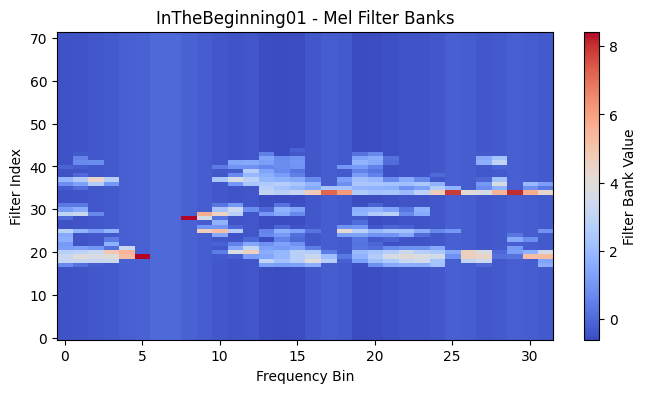

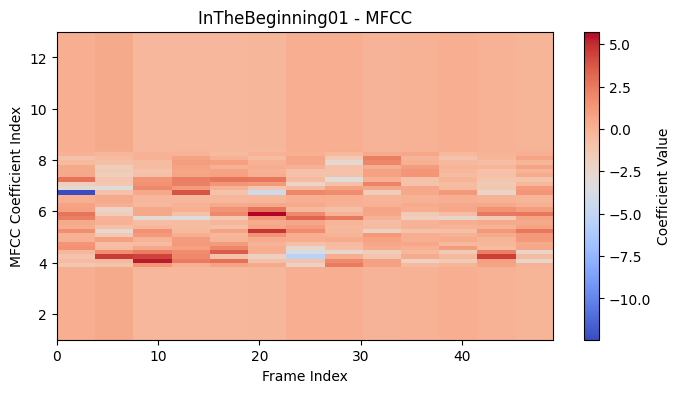

286764
(35840,) 22050
File name: InTheBeginning02



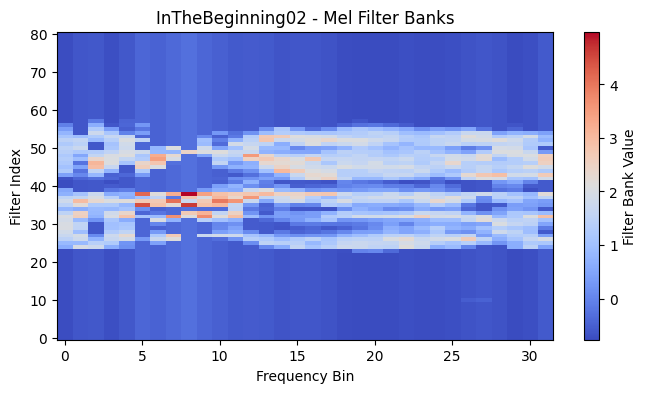

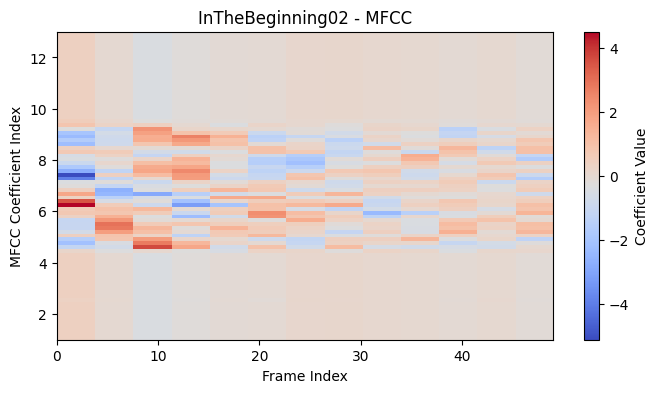

50424
(34715,) 22050
File name: inTheBeginning2



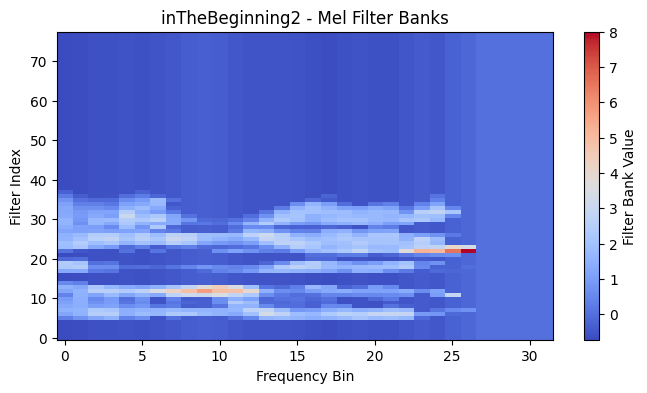

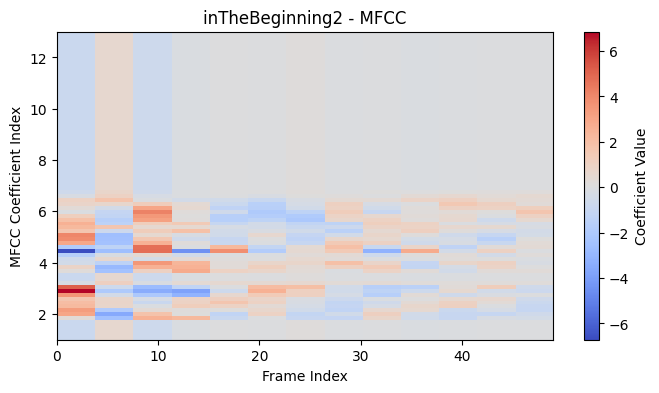

45942
(31627,) 22050
File name: jesus1



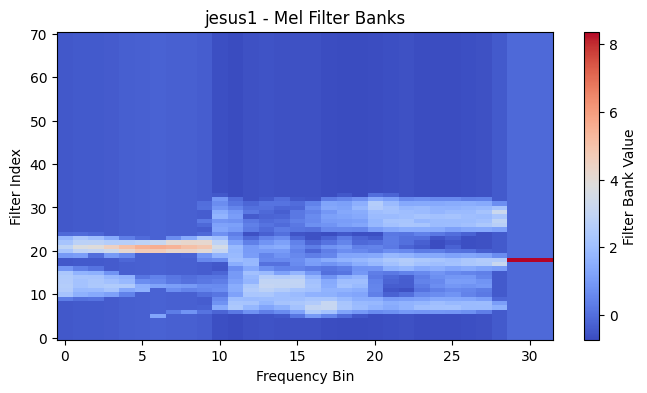

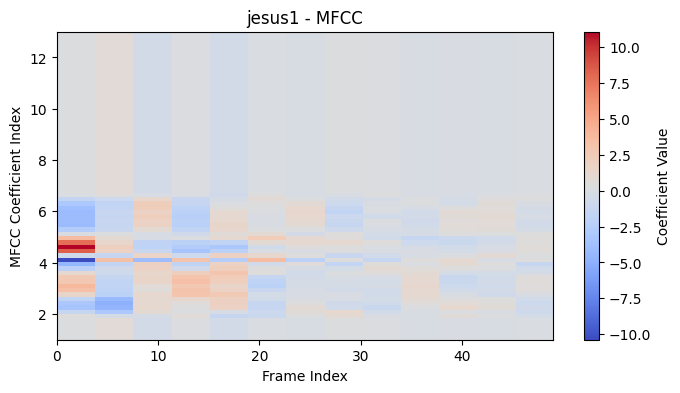

49626
(34166,) 22050
File name: jesus2



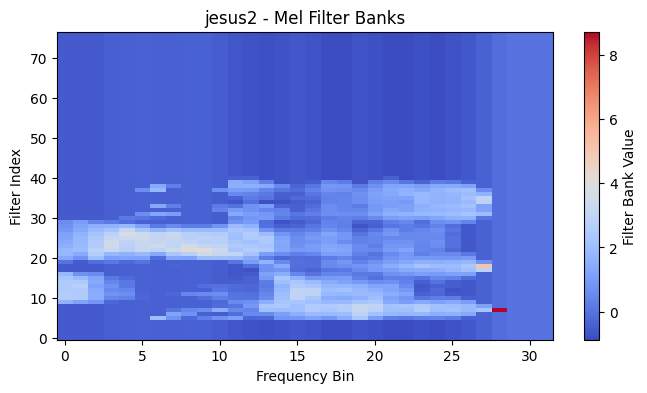

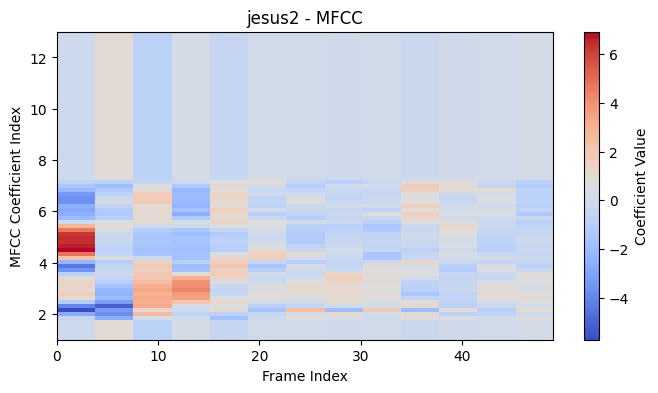

48662
(33501,) 22050
File name: wilderness1



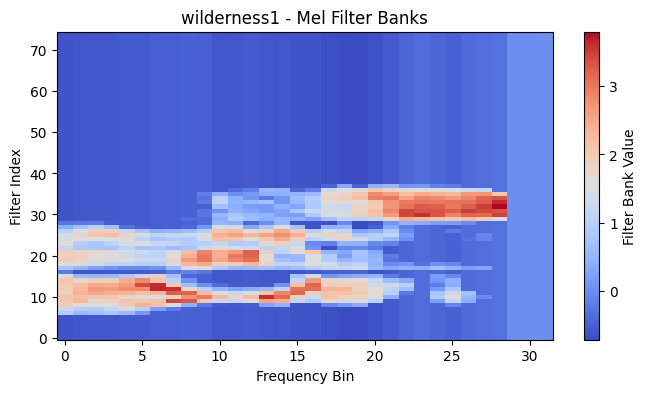

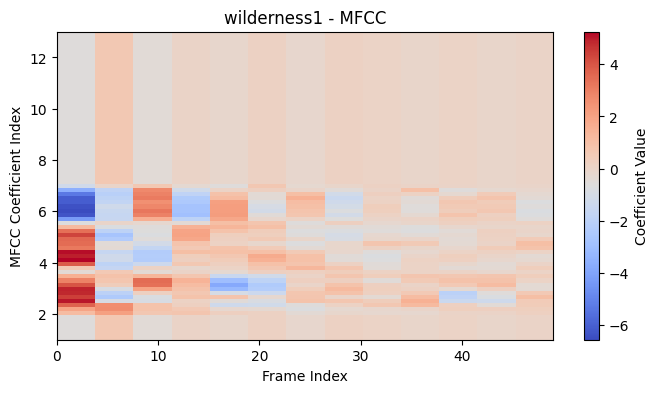

39706
(27330,) 22050
File name: God1



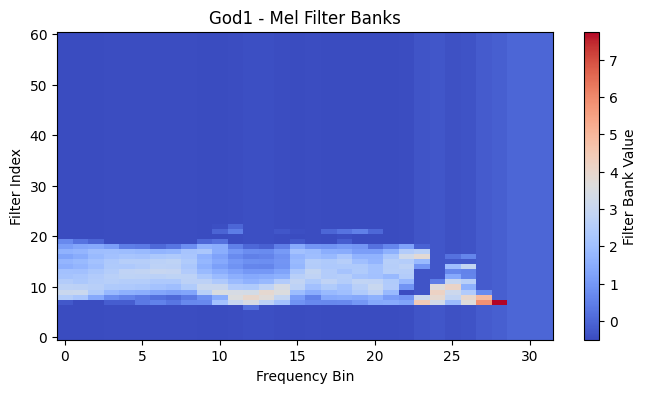

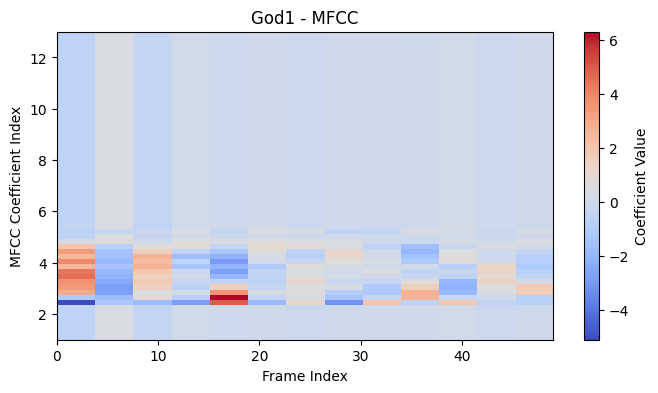

48024
(33062,) 22050
File name: wilderness2



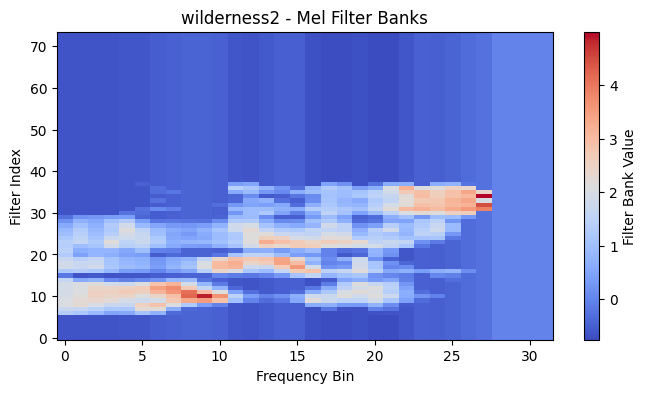

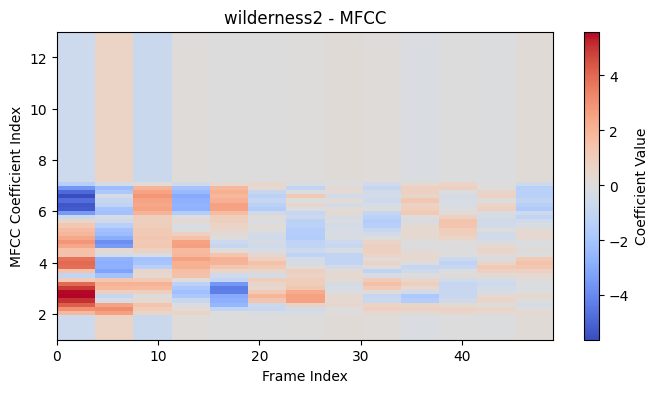

38906
(26779,) 22050
File name: God2



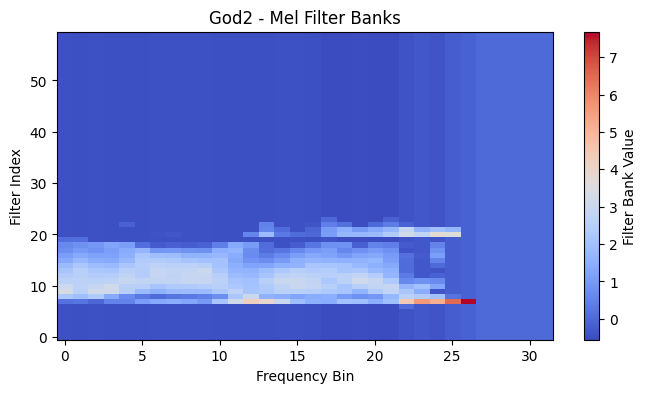

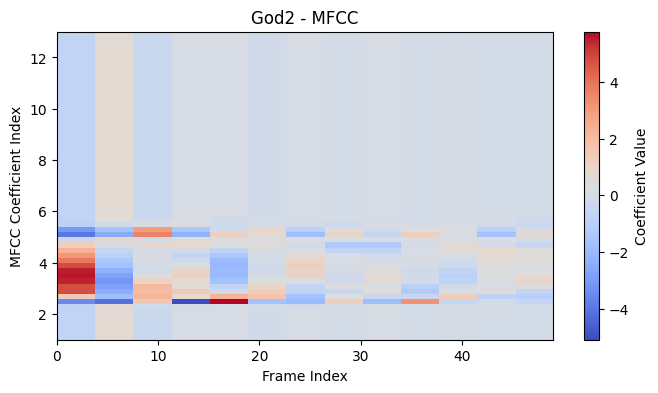

51542
(35486,) 22050
File name: inTheBeginning1



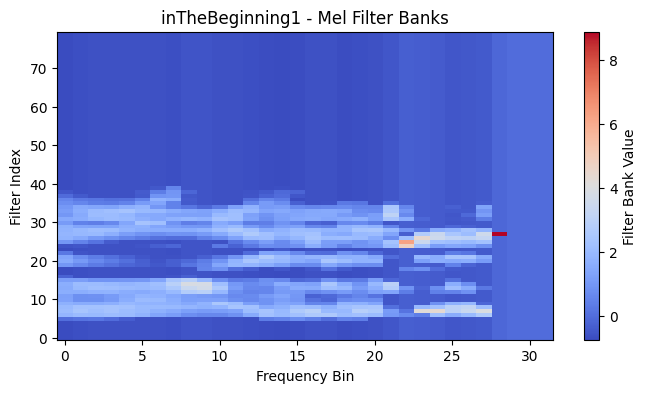

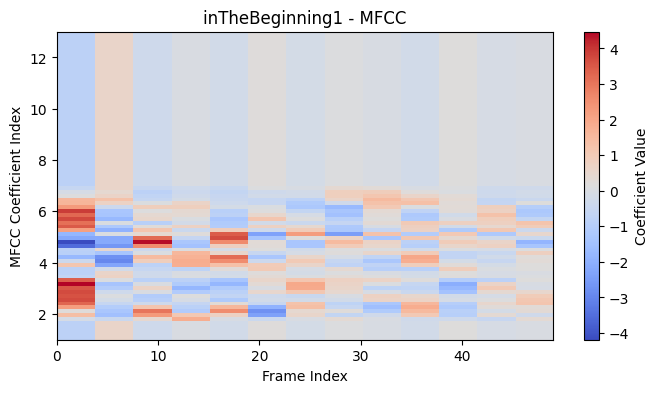

67764
(15555,) 22050
File name: God3



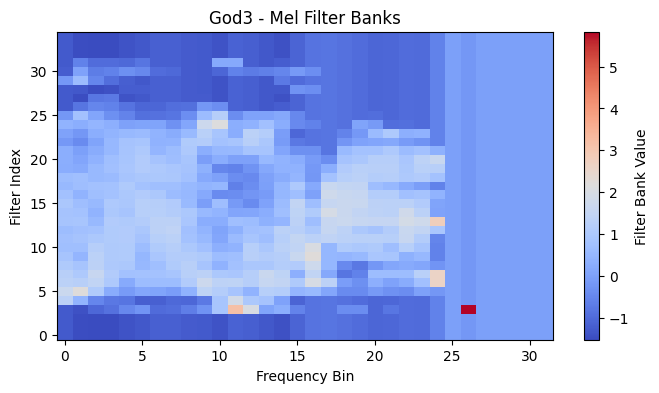

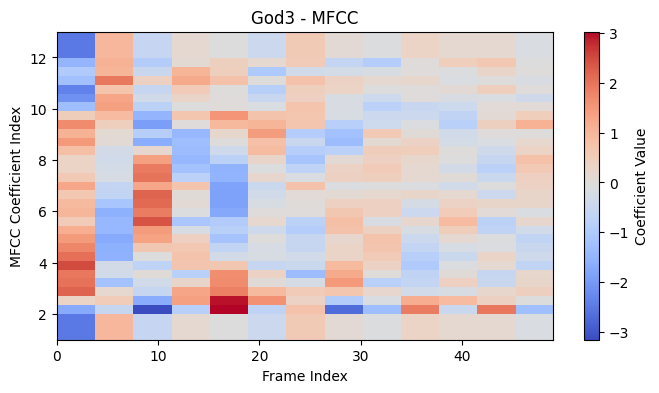

In [ ]:
# Loop filePaths calling calc_plot_mfcc_features for each filePath:
features = {}
for filePath in filePaths:
    audio_data, sample_rate = load_audio(filePrefix + filePath)
    file_name = os.path.splitext(os.path.basename(filePath))[0]  # Extract file name without extension
    print("File name:", file_name)
    print()  # Print a blank line
    features[filePath] = calc_plot_mfcc_features(
        audio_data,
        sample_rate,
        title=file_name,  # Correctly pass the title parameter
        **params
    )

48662
(33501,) 22050


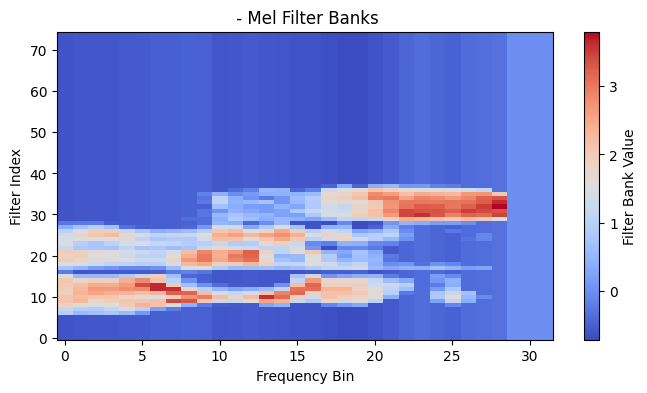

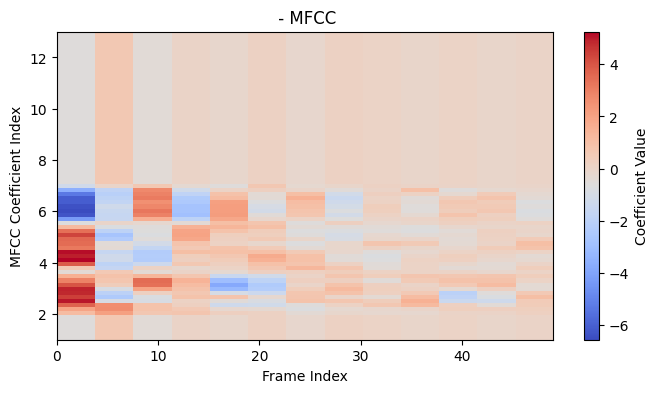

In [ ]:
target_audio_data, sample_rate = load_audio(target_file_path)  # Remove one instance of filePrefix
target_features = calc_plot_mfcc_features(
                        target_audio_data,
                        sample_rate,
                        **params
    )


In [ ]:
# Find the maximum length of feature vectors
max_length = max(len(vec) for vec in features.values())

# Pad feature vectors to the maximum length
features_array = np.array([vec + [0] * (max_length - len(vec)) for vec in features.values()])

# Verify the shape of features_array
print(features_array.shape)


(11, 1053)


In [ ]:
# Get the length of the target_feature list
length_of_target_feature = len(target_features)

# Print the length of the target_feature list
print("Length of target_feature:", length_of_target_feature)


Length of target_feature: 975


In [ ]:
def compute_similarities(mfcc_vectors, target_vectors, filePaths):
    # Convert target_vectors and mfcc_vectors to NumPy arrays if they are not already
    target_vectors = np.array(target_vectors)
    mfcc_vectors = np.array(mfcc_vectors)

    # Ensure 3D shape for compatibility
    if len(mfcc_vectors.shape) == 2:
        mfcc_vectors = np.expand_dims(mfcc_vectors, axis=0)
    if len(target_vectors.shape) == 2:
        target_vectors = np.expand_dims(target_vectors, axis=0)

    # Find the max length of the feature vectors
    max_length = max(mfcc_vectors.shape[2], target_vectors.shape[2])

    # Pad the shorter vectors with zeros to match the length of the longest vector
    mfcc_vectors = np.pad(mfcc_vectors, ((0, 0), (0, 0), (0, max_length - mfcc_vectors.shape[2])), mode='constant', constant_values=0)
    target_vectors = np.pad(target_vectors, ((0, 0), (0, 0), (0, max_length - target_vectors.shape[2])), mode='constant', constant_values=0)

    # Calculate similarities using cosine distance
    similarities = [1 - cosine(target_vec.flatten(), mfcc_vec.flatten()) for target_vec, mfcc_vec in zip(target_vectors, mfcc_vectors)]

    # Associate file paths with similarities
    named_similarities = {filePaths[i]: similarities[i] for i in range(len(filePaths))}
    # Sort by descending similarity
    named_similarities = dict(sorted(named_similarities.items(), key=lambda item: item[1], reverse=True))
    return named_similarities

In [ ]:
# Path to the target file
target_file_path = '/content/drive/MyDrive/2024 - unfoldingWord Hackathon/wilderness1.wav'
#target_file_path= "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/wilderness1.wav"

# Load target audio file and extract features
target_y, target_sr = librosa.load(target_file_path)
target_mfcc = librosa.feature.mfcc(y=target_y, sr=target_sr)

# Convert target_features to a NumPy array
target_features_array = np.array(target_mfcc)


In [ ]:
# Dictionary to store similarities
similarities_dict = {}

# Loop over all files in the folder

folder_path = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/"
#folder_path = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/"

for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
        # Load audio file and extract features
        audio_file_path = os.path.join(folder_path, filename)
        y, sr = librosa.load(audio_file_path)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)

        # Convert features to a NumPy array
        mfcc_array = np.array(mfcc)

        # Compute similarities
        similarities = compute_similarities(mfcc_array, [target_features_array], [filename])

        # Append the similarity value to the dictionary
        similarities_dict.update(similarities)

In [ ]:
# Print the results
print(f"Target file is Similar to {os.path.basename(target_file_path)}:")
for key, value in similarities_dict.items():
    print(f"{os.path.basename(key)}: Similarity = {value}")

Target file is Similar to wilderness1.wav:
InTheBeginning01.wav: Similarity = 0.8914556503295898
InTheBeginning02.wav: Similarity = 0.7733681797981262
inTheBeginning2.wav: Similarity = 0.9406983256340027
jesus1.wav: Similarity = 0.9158889055252075
jesus2.wav: Similarity = 0.9547539353370667
wilderness1.wav: Similarity = 1
God1.wav: Similarity = 0.7979349493980408
wilderness2.wav: Similarity = 0.9787302613258362
God2.wav: Similarity = 0.7821833491325378
inTheBeginning1.wav: Similarity = 0.9207169413566589
God3.wav: Similarity = 0.441738486289978


# Checking the word from the speech

A handful of packages for speech recognition exist on PyPI. A few of them include:



*   apiai
*   assemblyai
*   google-cloud-speech
*   pocketsphinx
*   SpeechRecognition
*   watson-developer-cloud
*   wit
Some of these packages—such as wit and apiai—offer built-in features, like natural language processing for identifying a speaker’s intent, which go beyond basic speech recognition. Others, like google-cloud-speech, focus solely on speech-to-text conversion.


Each Recognizer instance has seven methods for recognizing speech from an audio source using various APIs. These are:

* recognize_bing(): Microsoft Bing Speech
* recognize_google(): Google Web Speech API
* recognize_google_cloud(): Google Cloud Speech - requires installation of the * google-cloud-speech package
* recognize_houndify(): Houndify by SoundHound
* recognize_ibm(): IBM Speech to Text
* recognize_sphinx(): CMU Sphinx - requires installing PocketSphinx
* recognize_wit(): Wit.ai

Of the seven, only recognize_sphinx() works offline with the CMU Sphinx engine. The other six all require an internet connection.

Supported File Types
Currently, SpeechRecognition supports the following file formats:

* WAV: must be in PCM/LPCM format
* AIFF
* AIFF-C
* FLAC: must be native FLAC format; OGG-FLAC is not supported

In [ ]:
def count_occurrences(audio_file, tagged_word):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_file)
    occurrences = {word: 0 for word in tagged_word.split()}

    with audio as source:
        audio_data = recognizer.record(source)

        # Adjust for ambient noise in the audio
        recognizer.adjust_for_ambient_noise(source)

        # Split audio into segments based on silence
        audio_segment = AudioSegment.from_wav(audio_file)
        silent_ranges = detect_silence(audio_segment)

        segments = []
        start_time = 0
        for duration in silent_ranges:
            segment = audio_segment[start_time:start_time+duration]
            segments.append(segment)
            start_time += duration

        # Process each segment
        for segment in segments:
            try:
                segment.export("temp.wav", format="wav")  # Export the segment to a temporary WAV file
                with sr.AudioFile("temp.wav") as segment_source:
                    segment_audio_data = recognizer.record(segment_source)
                text = recognizer.recognize_google(segment_audio_data)
                for word in occurrences.keys():
                    if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE):
                        occurrences[word] += 1
            except sr.UnknownValueError:
                pass  # If speech recognition cannot understand the segment

    return occurrences

# Function to detect silence in an audio segment
def detect_silence(audio_segment, min_silence_len=1000, silence_thresh=-40):
    silent_ranges = []
    chunks = split_on_silence(audio_segment, min_silence_len=min_silence_len, silence_thresh=silence_thresh)
    for chunk in chunks:
        duration = len(chunk)  # Extract the duration of each chunk
        silent_ranges.append(duration)
    return silent_ranges

In [ ]:
# Example usage
audio_file = "/content/drive/MyDrive/2024 - unfoldingWord Hackathon/wilderness1.wav"
#folder_path = "/content/drive/MyDrive/Colab Notebooks/2024 - unfoldingWord Hackathon/wilderness1.wav"
tagged_word = "God"
occurrences = count_occurrences(audio_file, tagged_word)
print(occurrences)

{'God': 0}


In [ ]:
import speech_recognition as sr

r = sr.Recognizer()

with sr.AudioFile('/content/drive/MyDrive/2024 - unfoldingWord Hackathon/God1.wav') as source:
    audio = r.record(source)

r.recognize_google(audio, language='en-US')

'God'

# Text 1-1: Matthew 4:1

Then Jesus was led up by the Spirit into the wilderness to be tempted by the devil.

# Text 2-1: Luke 3:2a

...{the} word of God came to John, the son of Zechariah, in the wilderness.

# Text 2-1: Genesis 1:1

In the beginning God created the heavens and the earth.

# Text 2-2: John 1:1

In {the} beginning was the Word, and the Word was with God, and the Word was God.